### Notebook for MBON Data Mobilization Workshop: Apr 18-19 2023

##### Workshop agenda and resources found here: https://ioos.github.io/bio_mobilization_workshop/ 

##### DarwinCore Quick Reference Guide https://dwc.tdwg.org/terms/#dwc:measurementMethod


Information about this dataset: 
- Multi-Agency Rocky Intertidal Network (MARINe) Coastal Biodiversity Surveys (point contact): https://data.piscoweb.org/metacatui/view/doi%3A10.6085%2FAA%2Fmarine_cbs.5.5 

- Point Contact sampling consists of recording the diversity and abundance of invertebrates and algae along 11 transects of variable length extending from the upper intertidal to the low intertidal.

- For this dataset, I am using an Event Core with an Occurence Extension and EMoF.

In [47]:
## Imports

from datetime import date, datetime
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pyworms
#import pprint

## Load Data

In [48]:
## ----- ENTER VERSION NUMBER HERE -----

version = '5_5'

In [120]:
## Get directory info

folder = os.path.join('raw', 'resourceMap_marine_cbs_' + version, 'data')
filenames = [file for file in os.listdir(folder) if file.endswith('.txt') ]
filenames.sort()
filenames

['doi_10.6085_AA_marine_cbs.6.2-DATA.txt',
 'doi_10.6085_AA_marine_cbs.7.2-DATA.txt',
 'doi_10.6085_AA_marine_ltm.11.3-DATA.txt']

In [50]:
# Load data

data = pd.read_csv(os.path.join(folder, filenames[0]))
print(data.shape)

site = pd.read_csv(os.path.join(folder, filenames[2]))
print(site.shape)

species = pd.read_csv(os.path.join(folder, filenames[1]))
print(species.shape)

(151776, 21)
(274, 17)
(739, 14)


In [51]:
data.head(2)

,marine_site_name,site_code,latitude,longitude,survey_rep,year,Min(sample_date),Max(sample_date),species_lump,number_of_hits,...,percent_cover,state_province,georegion,bioregion,mpa_designation,mpa_region,mpa_lt_region,mpa_name,island,last_updated
0,Abalobadiah Creek,6009,39.569065,-123.77182,1,2015,2015-06-02,2015-06-02,Abietinaria/Amphisbetia spp,0,...,0.0,California,CA North,WA Olympic Coast to San Francisco,SMR,North Coast,North Coast,Ten Mile SMR,Mainland,2021-12-14
1,Abalobadiah Creek,6009,39.569065,-123.77182,1,2015,2015-06-02,2015-06-02,Acanthinucella spp,0,...,0.0,California,CA North,WA Olympic Coast to San Francisco,SMR,North Coast,North Coast,Ten Mile SMR,Mainland,2021-12-14


## Conversions

- Event: we will define an event as a single survey, captured by site ID, min date, max date. 
- Occurence: a single observation of an organism during a survey

In [52]:
# Start by creating an empty occurence dataframe

occ = pd.DataFrame()

In [53]:
## eventID

eventID = data['site_code'].astype(str) + '_' + data['Min(sample_date)'].astype(str) + '_' + data['Max(sample_date)'].astype(str)

eventID[0]

'6009_2015-06-02_2015-06-02'

In [54]:
# eventDate (given as an interval between two dates)

eventDate = data['Min(sample_date)'] + '/' + data['Max(sample_date)']
eventDate[0]

'2015-06-02/2015-06-02'

In [55]:
# add to occ dataframe, in addition to a few other important Darwin Core terms

occ['eventID'] = eventID
occ['eventDate'] = eventDate

# datasetName
occ['datasetName'] = 'MARINe CBS - percent cover from point contact surveys'

# basisOfRecord 
occ['basisOfRecord'] = 'HumanObservation'

# geodeticDatum
occ['geodeticDatum'] = 'WGS84'

# Depth
occ['minimumDepthInMeters'] = 0
occ['maximumDepthInMeters'] = 0

# samplingProtocol
occ['samplingProtocol'] = 'cbs point contact'

# coordinateUncertaintyInMeters
occ['coordinateUncertaintyInMeters'] = 350

In [56]:
occ.columns

Index(['eventID', 'eventDate', 'datasetName', 'basisOfRecord', 'geodeticDatum',
       'minimumDepthInMeters', 'maximumDepthInMeters', 'samplingProtocol',
       'coordinateUncertaintyInMeters'],
      dtype='object')

In [57]:
occ.head(2)

,eventID,eventDate,datasetName,basisOfRecord,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,coordinateUncertaintyInMeters
0,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350
1,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350


In [58]:
# Merge occurence table with site table to get coordinate locations, county, stateProvince, countryCode, decimalLat, decimalLon
# Note that I merged on marine_site_name here instead of site_code because the site codes are numeric in the data and strings in the site table. Rani confirmed this is the right thing to do.

occ['marine_site_name'] = data['marine_site_name']

# Define columns to merge from site table
site_cols = [
    'marine_site_name',
    'county',
    'state_province',
    'country',
    'latitude',
    'longitude',
]


# Define DwC terms for these columns after merge
dwc_cols = [
    'eventID',
    'eventDate',
    'datasetName',
    'basisOfRecord',
    'geodeticDatum',
    'minimumDepthInMeters',
    'maximumDepthInMeters',
    'samplingProtocol',
    'coordinateUncertaintyInMeters',
    'locality',
    'county',
    'stateProvince',
    'countryCode',
    'decimalLatitude',
    'decimalLongitude',
]

# Merge
occ = occ.merge(site[site_cols], how='left', on='marine_site_name')


In [59]:
len(occ.columns), len(dwc_cols)

(15, 15)

In [60]:
# Change column names to DwC
occ.columns = dwc_cols 

In [61]:
## Note there are a number of sites outside of the U.S. so using counties does not make sense here. Instead will change to np.nan
occ.loc[occ['county'] == 'Not Applicable', 'county'] = np.nan

In [62]:
# Add ISO 3166-1-alpha-2 country code: https://www.iso.org/obp/ui/#search 

occ['countryCode'] = occ['countryCode'].replace({'United States': 'US',
                                                 'Mexico': 'MX',
                                                 'Canada': 'CA'})

In [63]:
## occurrenceID (eventID + count number of occurence along a transect) 

occ['occurrenceID'] = data.groupby(['site_code', 
                                    'Min(sample_date)', 
                                    'Max(sample_date)'])['species_lump'].cumcount()+1


occ['occurrenceID'] = occ['eventID'] + '_' + occ['occurrenceID'].astype(str)

In [64]:
# occurrenceStatus

occ['percent_cover'] = data['percent_cover']

occ['occurrenceStatus'] = ''

# specify presence or absense for each row
occ.loc[occ.percent_cover == 0.0, ['occurrenceStatus']] = 'absent'
occ.loc[occ.percent_cover > 0.0, ['occurrenceStatus']] = 'present'

In [65]:
# organismQuantity information

occ['organismQuantity'] = data['percent_cover']
occ['organismQuantityType'] = 'Percent cover'


In [66]:
# occurrenceStatus

occ['occurrenceStatus'] = ''

# specify presence or absense for each row
occ.loc[occ.organismQuantity == 0.0, ['occurrenceStatus']] = 'absent'
occ.loc[occ.organismQuantity > 0.0, ['occurrenceStatus']] = 'present'

In [67]:
occ.head(2)

,eventID,eventDate,datasetName,basisOfRecord,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,coordinateUncertaintyInMeters,locality,county,stateProvince,countryCode,decimalLatitude,decimalLongitude,occurrenceID,percent_cover,occurrenceStatus,organismQuantity,organismQuantityType
0,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350,Abalobadiah Creek,Mendocino,California,US,39.569065,-123.77182,6009_2015-06-02_2015-06-02_1,0.0,absent,0.0,Percent cover
1,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350,Abalobadiah Creek,Mendocino,California,US,39.569065,-123.77182,6009_2015-06-02_2015-06-02_2,0.0,absent,0.0,Percent cover


#### ScientificName / WoRMS Lookup

Note that species_lump is defined as: The unique name that references the taxonomic, functional, morphologic, or geologic concept being observed. This is a lumped species name, and may include one or more final_classification values.

In [68]:
# Get species codes
occ['scientificName'] = data['species_lump']

In [69]:
# Create scientificName column in species table
sp = species[['species_lump', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']].copy()

sp.head(2)

,species_lump,kingdom,phylum,class,order,family,genus,species
0,Abietinaria/Amphisbetia spp,Animalia,Cnidaria,Hydrozoa,Leptothecata,Sertulariidae,NaN,NaN
1,Acanthina paucilirata,Animalia,Mollusca,Gastropoda,Neogastropoda,Muricidae,Acanthina,Acanthina paucilirata


In [70]:
# if the species name is unavailable, fill using family. If family is unavailable, fill using order... etc. 

sp['scientificName'] = sp['species']
sp['scientificName'] = sp['scientificName'].combine_first(sp['family'])
sp['scientificName'] = sp['scientificName'].combine_first(sp['order'])
sp['scientificName'] = sp['scientificName'].combine_first(sp['class'])
sp['scientificName'] = sp['scientificName'].combine_first(sp['phylum'])
sp['scientificName'] = sp['scientificName'].combine_first(sp['kingdom'])

print('number of unique names =' ,len(sp.scientificName.unique()))


number of unique names = 640


In [71]:
sp.head(2)

,species_lump,kingdom,phylum,class,order,family,genus,species,scientificName
0,Abietinaria/Amphisbetia spp,Animalia,Cnidaria,Hydrozoa,Leptothecata,Sertulariidae,NaN,NaN,Sertulariidae
1,Acanthina paucilirata,Animalia,Mollusca,Gastropoda,Neogastropoda,Muricidae,Acanthina,Acanthina paucilirata,Acanthina paucilirata


In [72]:
# Remove rows where species_lump = 'DROP'
sp = sp[sp['species_lump'] != 'DROP']

# Build dictionary mapping codes to names
sp_dict = dict(zip(sp['species_lump'], sp['scientificName']))

In [73]:
# Match abiotic names with themselves instead of np.nan
sp_dict.update({
    'Rock':'Rock',
    'Sand':'Sand',
    'Tar':'Tar',
}
)

In [74]:
# Get rid of "(Division)" designation in one dict value
sp_dict.update({
    'Red Crust':'Rhodophyta',
})

In [75]:
# Replace codes with names in sp_dict
occ['scientificName'] = occ['scientificName'].replace(sp_dict)
occ.head(2)

,eventID,eventDate,datasetName,basisOfRecord,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,coordinateUncertaintyInMeters,locality,...,stateProvince,countryCode,decimalLatitude,decimalLongitude,occurrenceID,percent_cover,occurrenceStatus,organismQuantity,organismQuantityType,scientificName
0,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350,Abalobadiah Creek,...,California,US,39.569065,-123.77182,6009_2015-06-02_2015-06-02_1,0.0,absent,0.0,Percent cover,Amphisbetia greenei
1,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350,Abalobadiah Creek,...,California,US,39.569065,-123.77182,6009_2015-06-02_2015-06-02_2,0.0,absent,0.0,Percent cover,Muricidae


In [76]:
print('number of unique scientificName entries =',len(occ['scientificName'].unique()))

number of unique scientificName entries = 383


In [78]:
# Use pyworms to match WoRMS scientificNameID, taxonRank, kingdom, match_type. 
# The print statements were commented out bc it was printing in a loop, but can be removed to see output. 
# Note this can take ~10 min to run. 

# Iterate row by row through the data frame and query worms for each ScientificName term.
for index, row in occ.iterrows():
    resp = pyworms.aphiaRecordsByMatchNames(row['scientificName'], marine_only=True)
      
   # When no matches are found, print the non-matching name and move on
    if len(resp[0]) == 0:
        #print('\nNo match for name "{}"'.format(row['scientificName']))
        continue
   
   # When more than 1 match is found, the user needs to take a look. But tell the user which one has multiple matches
    elif len(resp[0]) > 1:
        #print('\nMultiple matches for name "{}":'.format(row['scientificName']))
        #pprint.pprint(resp[0], indent=4)
        continue
   
   # When only 1 match is found, put the appropriate information into the appropriate row and column
    else:
        worms = resp[0][0]
        occ.loc[index, 'scientificNameID'] = worms['lsid']
        occ.loc[index, 'taxonRank'] = worms['rank']
        occ.loc[index, 'kingdom'] = worms['kingdom']
        occ.loc[index, 'match_type'] = worms['match_type']
        

In [79]:
# Based on pyworms query, make necessary manual changes based on multiple matches being found in several cases
occ.loc[occ.scientificName == 'Calliostoma canaliculatum', ['scientificNameID', 'taxonRank', 'kingdom' ]] = 'urn:lsid:marinespecies.org:taxname:467171', 'Species', 'Animalia'
occ.loc[occ.scientificName == 'Terebellidae', ['scientificNameID', 'taxonRank', 'kingdom' ]] = 'urn:lsid:marinespecies.org:taxname:982', 'Family', 'Animalia'
occ.loc[occ.scientificName == 'Serpula vermicularis', ['scientificNameID', 'taxonRank', 'kingdom' ]] = 'urn:lsid:marinespecies.org:taxname:131051', 'Species', 'Animalia'

#Tar is being changed to Lar Gosse (urn:lsid:marinespecies.org:taxname:158167). This needs to manually be changed as well.
occ.loc[occ.scientificName == 'Tar', ['scientificNameID', 'taxonRank', 'kingdom' ]] = '', '', ''


In [80]:
# I am using occurenceRemarks entry to define abiotic data. This was based on a similar approach taken in an OBIS dataset that Abby pointed me to: https://ipt-obis.gbif.us/resource?r=prcrmp_database#anchor-description 

occ['occurrenceRemarks'] = ''

# specify the type of abiotic observation for tar, sand, rock 
occ.loc[occ.scientificName == 'Tar', ['occurrenceRemarks']] = 'Abiotic - Tar'
occ.loc[occ.scientificName == 'Sand', ['occurrenceRemarks']] = 'Abiotic - Sand'
occ.loc[occ.scientificName == 'Rock', ['occurrenceRemarks']] = 'Abiotic - Rock'

# now, remove the abiotic terms from species columns
occ.loc[occ.scientificName == 'Tar', ['scientificName', 'scientificNameID', 'taxonRank', 'kingdom']] = '', '', '', ''
occ.loc[occ.scientificName == 'Sand', ['scientificName', 'scientificNameID', 'taxonRank', 'kingdom']] = '', '', '', ''
occ.loc[occ.scientificName == 'Rock', ['scientificName', 'scientificNameID', 'taxonRank', 'kingdom']] = '', '', '', ''


In [81]:
# We can remove the match_type column
occ.drop(columns=['match_type'], inplace=True)

In [85]:
occ[occ['occurrenceRemarks'] == 'Abiotic - Rock'].head(2)

,eventID,eventDate,datasetName,basisOfRecord,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,coordinateUncertaintyInMeters,locality,...,occurrenceID,percent_cover,occurrenceStatus,organismQuantity,organismQuantityType,scientificName,scientificNameID,taxonRank,kingdom,occurrenceRemarks
349,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350,Abalobadiah Creek,...,6009_2015-06-02_2015-06-02_350,23.222322,present,23.222322,Percent cover,,,,,Abiotic - Rock
757,89_2012-02-03_2012-02-03,2012-02-03/2012-02-03,MARINe CBS - percent cover from point contact ...,HumanObservation,WGS84,0,0,cbs point contact,350,Abalone Cove,...,89_2012-02-03_2012-02-03_350,48.272458,present,48.272458,Percent cover,,,,,Abiotic - Rock


### Make Event Core

In [87]:
event = occ[['eventID', 
             'eventDate', 
             'decimalLatitude', 
             'decimalLongitude', 
             'samplingProtocol', 
             'locality', 
             'county', 
             'stateProvince', 
             'countryCode', 
             'geodeticDatum', 
             'minimumDepthInMeters', 
             'maximumDepthInMeters',
             'coordinateUncertaintyInMeters']].copy()
event.drop_duplicates(inplace=True)
event.reset_index(inplace=True,drop=True)
event.head(2)

,eventID,eventDate,decimalLatitude,decimalLongitude,samplingProtocol,locality,county,stateProvince,countryCode,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,coordinateUncertaintyInMeters
0,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,39.569065,-123.77182,cbs point contact,Abalobadiah Creek,Mendocino,California,US,WGS84,0,0,350
1,89_2012-02-03_2012-02-03,2012-02-03/2012-02-03,33.737782,-118.37612,cbs point contact,Abalone Cove,Los Angeles,California,US,WGS84,0,0,350


In [88]:
print('number of unique events =', len(event.eventID.unique()))

number of unique events = 372


In [118]:
## Save

today = date.today().strftime('%Y%m%d')
output_filename = 'event_core_' + today + '.csv'

event.to_csv(os.path.join(os.getcwd()+'/processed/', output_filename), index=False)

### Make Occurrence Extension

In [106]:
occ_ext = occ[['eventID', 
               'occurrenceID', 
               'datasetName', 
               'basisOfRecord', 
               'scientificName', 
               'scientificNameID', 
               'taxonRank', 
               'kingdom', 
               'occurrenceStatus',
               'occurrenceRemarks',
               'organismQuantity',
               'organismQuantityType'
                ]].copy()

In [108]:
occ_ext.head(2)

,eventID,occurrenceID,datasetName,basisOfRecord,scientificName,scientificNameID,taxonRank,kingdom,occurrenceStatus,occurrenceRemarks,organismQuantity,organismQuantityType
0,6009_2015-06-02_2015-06-02,6009_2015-06-02_2015-06-02_1,MARINe CBS - percent cover from point contact ...,HumanObservation,Amphisbetia greenei,urn:lsid:marinespecies.org:taxname:1358362,Species,Animalia,absent,,0.0,Percent cover
1,6009_2015-06-02_2015-06-02,6009_2015-06-02_2015-06-02_2,MARINe CBS - percent cover from point contact ...,HumanObservation,Muricidae,urn:lsid:marinespecies.org:taxname:148,Family,Animalia,absent,,0.0,Percent cover


In [117]:
## Save

today = date.today().strftime('%Y%m%d')
output_filename = 'occurence_extension_' + today + '.csv'

occ_ext.to_csv(os.path.join(os.getcwd()+'/processed/', output_filename), index=False)

### Make Extended Measurement or Fact Extension

In [110]:
#more info about MoF https://dwc.tdwg.org/terms/#measurementorfact 

emof = occ[['eventID', 
            'occurrenceID', 
            'organismQuantity',
            'organismQuantityType'
           ]].copy()

emof.rename(columns={
    'organismQuantityType':'measurementType',
    'organismQuantity':'measurementValue'
}, inplace=True)

# The measurementType was suggested to me during the MBON data mobilization workshop. Link to the P01 vocabulary on NVS: http://vocab.nerc.ac.uk/collection/P01/current/SDBIOL10/ 
# link to P01 search tool: https://vocab.seadatanet.org/p01-facet-search?&step_more=2

emof['measurementType'] = 'Coverage (in assayed sample) of biological entity specified elsewhere of the bed'
emof['measurementTypeID'] = 'http://vocab.nerc.ac.uk/collection/P01/current/SDBIOL10/'
emof['measurementUnit'] = 'percent'
emof['measurementUnitID'] = 'http://vocab.nerc.ac.uk/collection/P06/current/UPCT/' # note that units are also using controlled vocab (P06) 

In [111]:
emof.head(2)

,eventID,occurrenceID,measurementValue,measurementType,measurementTypeID,measurementUnit,measurementUnitID
0,6009_2015-06-02_2015-06-02,6009_2015-06-02_2015-06-02_1,0.0,Coverage (in assayed sample) of biological ent...,http://vocab.nerc.ac.uk/collection/P01/current...,percent,http://vocab.nerc.ac.uk/collection/P06/current...
1,6009_2015-06-02_2015-06-02,6009_2015-06-02_2015-06-02_2,0.0,Coverage (in assayed sample) of biological ent...,http://vocab.nerc.ac.uk/collection/P01/current...,percent,http://vocab.nerc.ac.uk/collection/P06/current...


In [116]:
## Save

today = date.today().strftime('%Y%m%d')
output_filename = 'emof_' + today + '.csv'

#emof.to_csv(os.path.join(os.getcwd(), output_filename), index=False)
emof.to_csv(os.path.join(os.getcwd()+'/processed/', output_filename), index=False)

In [115]:
os.path.join(os.getcwd())+'/processed/'

'/Users/mlebrec/Desktop/data/MARINe/MBON_workshop_Apr2023/processed'

### QA/QC Steps

/Users/mlebrec/miniconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


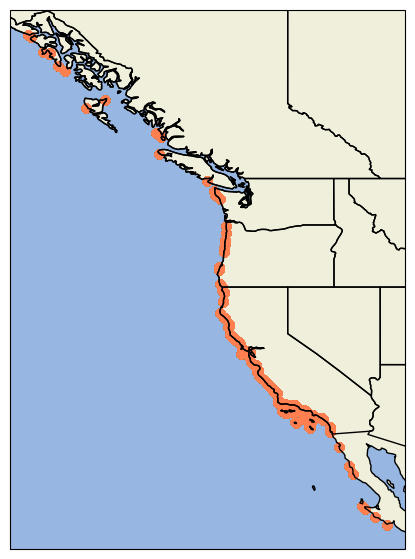

In [93]:
# Create map of data to check for any errors in coordinates

plt.figure(figsize=[10,7])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.OCEAN)
plt.scatter(occ.decimalLongitude, occ.decimalLatitude, c='coral')

In [94]:
## check that all required Darwin Core terms are present

required_dwc_terms = (['occurrenceID',
            'basisOfRecord',
            'scientificName',
            'scientificNameID',
            'eventDate',
            'decimalLatitude',
            'decimalLongitude',
            'occurrenceStatus',
            'countryCode',
            'kingdom',
            'geodeticDatum'
])

my_dwc_terms = occ_ext.columns.append(event.columns)

check =  all(item in my_dwc_terms for item in required_dwc_terms)
if check is True:
    print("The list {} contains all elements of the list {}".format(required_dwc_terms, my_dwc_terms))    
else :
    print("No, my_dwc_terms doesn't have all elements of the required_dwc_terms.")

The list ['occurrenceID', 'basisOfRecord', 'scientificName', 'scientificNameID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'occurrenceStatus', 'countryCode', 'kingdom', 'geodeticDatum'] contains all elements of the list Index(['eventID', 'occurrenceID', 'datasetName', 'basisOfRecord',
       'scientificName', 'scientificNameID', 'taxonRank', 'kingdom',
       'occurrenceStatus', 'organismQuantity', 'organismQuantityType',
       'eventID', 'eventDate', 'decimalLatitude', 'decimalLongitude',
       'samplingProtocol', 'locality', 'county', 'stateProvince',
       'countryCode', 'geodeticDatum', 'minimumDepthInMeters',
       'maximumDepthInMeters', 'coordinateUncertaintyInMeters'],
      dtype='object')


In [95]:
# Run basic statistics on organismQuantity 
occ_ext.describe()

,organismQuantity
count,151776.000000
mean,0.312687
std,2.051405
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,74.324324


<Axes: >

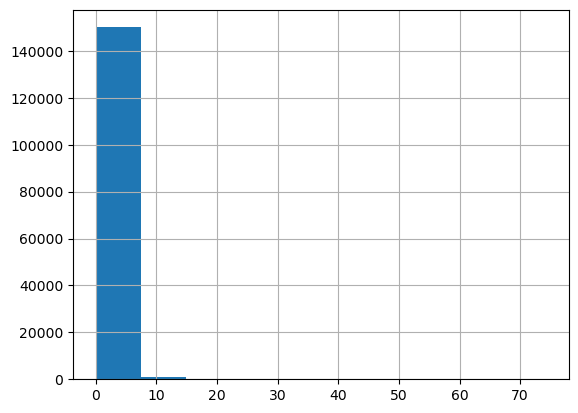

In [96]:
# the vast majority of the dataset are absent occurrences.
occ_ext['organismQuantity'].hist()

In [97]:
print('% of observations with presence of species =', (len(occ_ext[occ_ext.occurrenceStatus == 'present']) / len(occ_ext[occ_ext.occurrenceStatus == 'absent'])) *100)

% of observations with presence of species = 15.466427278121813


In [98]:
# Check for uniqueness of occurrenceID field

len(occ_ext.occurrenceID.unique()), len(occ_ext)

(151776, 151776)

In [99]:
# Check for uniqueness of eventID field

len(event.eventID.unique()), len(event)

(372, 372)

#### Questions for Rani
- Just to make sure I am interpreting the data correctly, the percent cover that is recorded is for an entire transect, correct? Since there is no way of identifying a specific quadrat within a transect (if that is how transects were taken), I assume I am interpreting correctly but maybe I'm missing something.
**RG: The percent cover is for the entire site, based on the number of transect locations (typically 11 for each site). Since we do include layering the total percent cover may be more than 100%**

- Diana had started a Python notebook to convert the MARINe point contact data to DarwinCore. For the term "coordinateUncertaintyInMeters" (linked here), Diana had used 350 m. I want to confirm with you that that value should still be used? 
Is the 350 m the maximum length of a transect and therefor the uncertainty in the exact point a measurement is made?
**RG: Actually this is because we use a single point for our sites (either the most upcoast coordinate or the center point), and 350m is the maximum distance away any of our plots are from one of the single point coordinates.**

- In the site information table (doi_10.6085_AA_marine_ltm.11.3-DATA.txt), the site_code column includes strings with letters for each site. In the data table (doi_10.6085_AA_marine_cbs.6.2-DATA.txt), the site_code column includes numbers. Since the site_code can't be linked between tables, I used the marine_site_name from each table as common identifiers. I just want to make sure that is the right approach, and that the marine_site_name are indeed consistent between tables. 
**RG: Yes! The next time I update the biodiversity data I will be including the marine_site_code as well - we had two different codes for the different surveys but we have a letter code for all of the numeric biodiversity codes, and the marine_site_name is the correct way to link them!**

- Do you know what the correct geodetic datum is used for these data? The standard is World Geodetic System 1984 (WGS84) but if it is something else, I can specify it for OBIS
**RG: We use WGS84**


#### Questions for workshop
- How to handle abiotic data? **Abby suggests leaving it in and OBIS will pick it out. Similar example here: https://ipt-obis.gbif.us/resource?r=prcrmp_database** 
- I have one species which is not marine. Is it okay to include? (Cancer antennaria). **You can include it but it will be flagged by OBIS as a non-marine species.**
- How to handle NaN values? **OBIS prefers you use "" when you have a blank rather than NaN or NA.**